In [2]:
from os import path
import numpy as np
import cv2
import time
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from matplotlib import pyplot as plt
import tensorflow as tf
#tf.test.gpu_device_name()


In [3]:
#path = 'drive/Shared drives/539Final/'
path = ""
# read iris.csv
legend = pd.read_csv(path + 'legend.csv').to_numpy()

# split into label and identifiers
tmp_labels = legend[:, 2]
tmp_pic_names = legend[:, 1]
tmp_labels = np.array([i.lower() for i in tmp_labels])
print(tmp_pic_names.shape)


(13690,)


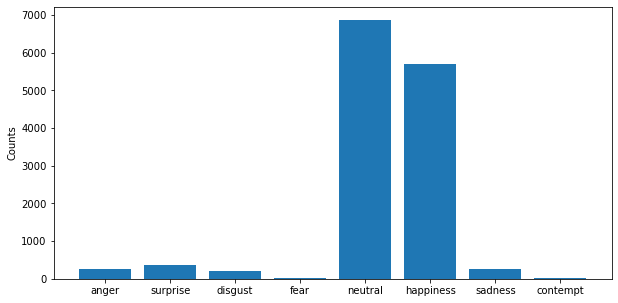

In [4]:
import collections
counter = collections.Counter(tmp_labels)
x = [i for i in counter]
y = [counter[i] for i in counter]

plt.figure(figsize=(10,5))
plt.bar(x, y)
plt.ylabel('Counts')
plt.show()

In [5]:
#Data Preprocessing
folder = 'images/'
imgs = []
for name in tmp_pic_names[:]:
    
    #read the img
    img = cv2.imread(folder+name)
    #resize
    final_img = cv2.resize(img, (128,128))
    
    imgs.append(final_img)

In [4]:
# autoencode labels for training
onehot_encoder = OneHotEncoder(sparse=False)
labels = onehot_encoder.fit_transform(tmp_labels.reshape(-1, 1))

# feature list for reverse transform
print(onehot_encoder.get_feature_names())

['x0_anger' 'x0_contempt' 'x0_disgust' 'x0_fear' 'x0_happiness'
 'x0_neutral' 'x0_sadness' 'x0_surprise']


In [5]:
input = np.array(imgs)
label = np.array(labels)

In [ ]:
# save processed data for later use
np.save('input_incep_v3', imgs)
np.save('labels_incep_v3', labels)

In [ ]:
input = np.load('input_incep_v3.npy')
label = np.load('labels_incep_v3.npy')

In [8]:
#import model from keras
from keras.models import Model
from keras.applications import ResNet50
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, UpSampling2D, BatchNormalization
from keras.applications.inception_v3 import InceptionV3
#from keras.applications.inception_v3 import preprocess_input
from keras.applications.resnet import preprocess_input
from keras import Sequential

resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(128,128,3))
#InceptionV3_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(128,128,3))


94773248/94765736 [==============================] - 0s 0us/step


In [9]:
CLASSES = label.shape[1]
print('Classes:', CLASSES)

model = Sequential()
model.add(resnet_model)
#model.add(InceptionV3_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(256, activation='relu'))
model.add(Dropout(.25))
model.add(BatchNormalization())
model.add(Dense(CLASSES, activation='softmax'))

for layer in resnet_model.layers:
    #if isinstance(layer, BatchNormalization):
        #layer.trainable = True
    #else:
    layer.trainable = False

Classes: 8


In [10]:
from sklearn.model_selection import train_test_split
#split out the test data
X_train, X_test, y_train, y_test = train_test_split(input, label, test_size=0.3, random_state=0)


X_train = preprocess_input(X_train)
X_test = preprocess_input(X_test)

print(X_train.shape)
print(y_train.shape)

print(X_test.shape)
print(y_test.shape)

(9583, 128, 128, 3)
(9583, 8)
(4107, 128, 128, 3)
(4107, 8)


In [11]:
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [12]:
start_time = time.time()
EPOCHS = 100
STEPS_PER_EPOCH = 2
MODEL_FILE = 'final_test1.model'

history = model.fit(
    x = X_train, y = y_train,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_split= 0.2,
    shuffle = True)
  
model.save(MODEL_FILE)
print(f"Time consumed for {EPOCHS} epochs: {(time.time() - start_time )/60 // 0.01 * 0.01} mins")

Epoch 1/100
2/2 [==============================] - 9s 4s/step - loss: 2.4680 - accuracy: 0.3054 - val_loss: 1.9714 - val_accuracy: 0.6244
Epoch 2/100
2/2 [==============================] - 10s 5s/step - loss: 1.6532 - accuracy: 0.5547 - val_loss: 1.8390 - val_accuracy: 0.6348
Epoch 3/100
2/2 [==============================] - 10s 5s/step - loss: 1.4029 - accuracy: 0.6312 - val_loss: 1.5909 - val_accuracy: 0.6390
Epoch 4/100
2/2 [==============================] - 10s 5s/step - loss: 1.2393 - accuracy: 0.6826 - val_loss: 1.4855 - val_accuracy: 0.6442
Epoch 5/100
2/2 [==============================] - 9s 5s/step - loss: 1.1314 - accuracy: 0.7154 - val_loss: 1.0804 - val_accuracy: 0.7079
Epoch 6/100
2/2 [==============================] - 9s 5s/step - loss: 1.0382 - accuracy: 0.7378 - val_loss: 1.0710 - val_accuracy: 0.7079
Epoch 7/100
2/2 [==============================] - 10s 5s/step - loss: 0.9795 - accuracy: 0.7469 - val_loss: 1.0359 - val_accuracy: 0.7246
Epoch 8/100
2/2 [=============

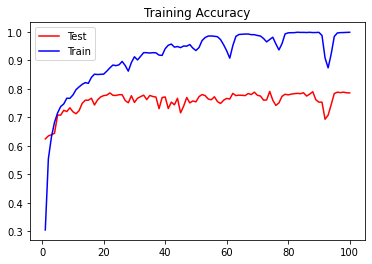

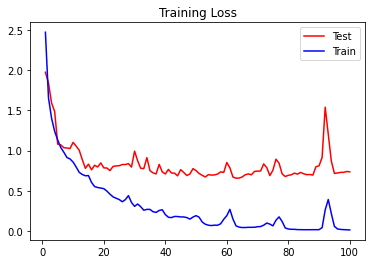

In [14]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
epochs = range(1,len(acc)+1)

plt.plot(epochs, val_acc,'r', label = 'Test')
plt.plot(epochs, acc,'b', label = 'Train')
plt.title("Training Accuracy")
plt.legend()

plt.figure()
plt.plot(epochs, val_loss,'r', label = 'Test')
plt.plot(epochs,loss,'b', label = 'Train')
plt.title("Training Loss")

plt.legend()
plt.show()

In [15]:
 #test result
 test = model.evaluate(x = X_test, y = y_test)

129/129 [==============================] - 5s 38ms/step - loss: 0.7213 - accuracy: 0.7879
